In [1]:
import numpy as np
from Bio import Phylo
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd
from torch.utils.data import TensorDataset, DataLoader
import io
import os
import matplotlib.pyplot as plt

## Contents  
1. [Preproccess](#preproccess)  
2. [Model Defintion](#model)  
3. [Training](#train)  
4. [Evaluation](#eval)  
5. [Branch Function Setup](#function)

## 1. Preproccess
<a id = 'preprocess'></a>

### 1a. Functions for Network Input

In [2]:
#functions to be applied tree-wise
def tree_depth(tree):
    '''given a tree in newick format, return overall depth'''
    
    tree = Phylo.read(io.StringIO(tree), 'newick')
    max_depth = max(tree.depths().values())
    
    return max_depth

def branch_ratio(data, tree_data, index):
    '''given a data_row with form [[parent ,child, branch_length]],
    return data_row with ratios of branch lengths'''
    
    tree = tree_data[tree_data['dreamID'] == index]['ground'].item()
    max_depth = tree_depth(tree)
    
    transformed_data = data #initialize
    for i in range(len(data)):
        transformed_data[i][2] = data[i][2] / max_depth
    
    return transformed_data

In [3]:
#functions to be applied trit-wise
def trit_det(parent, child):
    '''Given two trits from parent node 1 and child node 2 joined by an edge,
    return labeled mutation:
    1 -> 2 = 0
    1 -> 0 = 1
    1 -> 1 (no change) = 2
    2 -> 2/ 0 -> 0 (no change) = 2
    '''
    
    if parent == '1':
        if child == '2':#1->2
            return 0
        elif child == '0':#1->0
            return 1
        else: #'1' -> '1'
            return 2
    else:#no mutation
        return 2

def barcode_det(parent, child):
    '''Given two barcodes from parent node 1 and child node 2 joined by an edge,
    return a 10x3 with 0, 1, 2'''
    
    parent = str(parent)
    child = str(child)
    mutation_vector = [trit_det(parent[i],child[i]) for i in range(10)]
    
    mutation_array = np.zeros((10, 3))#10 trites, 3 categories
    for i in range(10):
        mutation_array[i, mutation_vector[i]] = 1
    
    return mutation_array


### 1b. Processing of  Data, TVT Split

In [4]:
def convert_pair(tree):
    '''Given a data row of form [[parent,child,branch_length]]
    return Nx21 array s.t the first 20 columns represent the input and the final 1 represents branch length'''
    
    #initialize
    converted_tree = np.zeros((len(tree), 21))
    i = 0
    for pair in tree:
        mut_array = barcode_det(pair[0], pair[1])[:,0:2].reshape(20,)
        converted_pair = np.hstack((mut_array, np.array(pair[2])))#I don't care about final row
        converted_tree[i, :] = converted_pair
        i +=1
    
    return converted_tree
#final preproccessing function
def load_from_txt(data):
    '''Given a .txt file of the data, return an array'''
    loaded_data = []
    
    with open(data) as infile:
        lines = infile.readlines()
        for line in lines:
            line_list = line[2:len(line)-4].split('], ')
            new_line_list = []
            for pair in line_list:#[parent,child,branchlength] objects
                pair = pair[1:].split(', ')
                new_pair = pair
                new_pair[2] = float(pair[2])
                new_line_list.append(new_pair)
            loaded_data.append(new_line_list)
            
    return np.array(loaded_data)


def preproccess(train_data, test_data, reference, split = 30):
    '''
    train_data/test_data - .txt files that reflect parent-child node pairs for each tree
    reference - NEWICK format tree data (train/test derived from this set)
    split - train/test split, dependant on guidelines
    returns N x 2 Array s.t 1 column is a 10x3 array and another is the branch length
    '''
    DREAM_data = pd.read_csv(reference, sep = '\t')
    DREAM_train = DREAM_data[split:]
    DREAM_test = DREAM_data[:split]

    test_data_raw = load_from_txt(test_data)
    train_data_raw = load_from_txt(train_data)

    reformat_train = []
    reformat_test = []

    reformat_pair = [reformat_train, reformat_test]
    DREAM_pair = [DREAM_train, DREAM_test]
    data_pair = [train_data_raw, test_data_raw]


    for k in range(2): #0 = train, 1 = test
        for i in range(1, data_pair[k].shape[0]):
            tree_row = data_pair[k][i]
            tree_row = branch_ratio(tree_row, DREAM_pair[k], i)
            reformat_row = convert_pair(tree_row)
            reformat_pair[k].extend(reformat_row)#all pairs put together
    
    return reformat_pair

all_data = preproccess('Data/trainingDataFinalOutput.txt',
                       'Data/testingDataFinalOutput.txt',
                       'Data/DREAM_data_intMEMOIR.csv')

train_validate_data = np.vstack(all_data[0])
#will mix up all of our trees, removing bias
np.random.shuffle(train_validate_data)

#tvt split is (908-386):386:386 for #pairs
train_data = train_validate_data[:(908 - 386), :]#will split off 386 pairs for validation
validate_data = train_validate_data[(908 - 386):, :]
test_data = np.vstack(all_data[1])

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: `item` has been deprecated and will be removed in a future version
  


### 1c. Loader Definition

In [5]:
def loader(data, batch_size = 1):
    '''
    Accepts data array of form Nx2 for the first column of input
    and the 2nd column of ground truth.
    Returns DataLoader object with specific batch_size
    '''
    data_input , data_label = torch.from_numpy(data[:, :20]).type(torch.FloatTensor),\
                              torch.from_numpy(data[:, 20]).type(torch.FloatTensor)
    dataTensorSet = TensorDataset(data_input, data_label)
    dataLoader = DataLoader(dataTensorSet, batch_size = batch_size)
    
    return dataLoader

trainLoader = loader(train_data, batch_size = 32)
validateLoader = loader(validate_data, batch_size = 32 * 2)
testLoader = loader(test_data, batch_size = 1)

### 2. Model Definition
<a id = 'model'></a>

In [6]:
class model(nn.Module):
    '''
    1 layer FC, trained to find linear relationship between 2 types of mutations for 10 trits
    and branch length
    '''
    
    def __init__(self):
        super(model, self).__init__()
        
        self.fc = nn.Linear(20, 1)
    def forward(self, x):
        output = self.fc(x)
        return output


In [7]:
#hyperparameter/extra function definition
BRANCH_MODEL = model()
LR = 1e-4
EPOCHS = 400
optimizer = optim.Adam(BRANCH_MODEL.parameters(), lr = LR)
criterion = nn.SmoothL1Loss()
score = nn.MSELoss()#want to minimize this
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor = 0.85, patience = 2, verbose = True)

model_save_path = 'saved_models/'
best_model_path = os.path.join(model_save_path, 'Best_Brancher.pth')

### 3. Training
<a id = 'train'></a>

In [123]:
last_score = np.inf
history = {'train_epoch_loss': [], 'validate_epoch_loss': []}
for epoch in range(EPOCHS):
    
    train_epoch_loss, validate_epoch_loss, epoch_score, batch_n = 0, 0, 0, 0
    ### TRAIN ###
    BRANCH_MODEL.train()
    for batch_i, (train_input, train_label) in enumerate(trainLoader):
        batch_n += 1
        predicted_label = BRANCH_MODEL(train_input).view(train_input.shape[0])
        #reset the gradient
        optimizer.zero_grad()
        
        #compute loss
        loss = criterion(predicted_label, train_label)
        train_epoch_loss += loss
        
        #backpropagate loss
        loss.backward()
        #update parameters
        optimizer.step()
        
    train_epoch_loss = train_epoch_loss / batch_n #average Smooth L1
    
    ### VALIDATE ###
    #NOTE: BATCH_SIZE = SAMPLE SPACE, so 
    batch_n = 0
    BRANCH_MODEL.eval()
    for batch_i, (validate_input, validate_label) in enumerate(validateLoader):
        batch_n += 1
        predicted_label = BRANCH_MODEL(train_input)

        #compute loss
        loss = criterion(predicted_label, validate_label)
        validate_epoch_loss += loss

        #compute score
        batch_score = score(predicted_label, validate_label)
        epoch_score += batch_score
        
    validate_epoch_loss = validate_epoch_loss/ batch_n
    epoch_score = epoch_score / batch_n
    
    history['train_epoch_loss'].append(train_epoch_loss)
    history['validate_epoch_loss'].append(validate_epoch_loss)        
    
    #reduce LR On Plateau
    scheduler.step(validate_epoch_loss)
    
    #print logs
    print(f'Epoch: {epoch} | ', end = '')
    print(f'Train Loss: {train_epoch_loss:.3f} | ', end = '')
    print(f'Validation Loss: {validate_epoch_loss:.3f} | ', end = '')
    print(f'Validation Score: {epoch_score:.3f} | ', end = '')
    #save best model
    if last_score > epoch_score:
        torch.save(BRANCH_MODEL.state_dict(), best_model_path)
        last_score = epoch_score
        print(f'\nBest model saved @ Epoch: {epoch}, Score: {epoch_score:.3f}')
    else:
        print()

    

Epoch: 0 | Train Loss: 0.027 | Validation Loss: 0.024 | Validation Score: 0.047 | 
Best model saved @ Epoch: 0, Score: 0.047
Epoch: 1 | Train Loss: 0.027 | Validation Loss: 0.023 | Validation Score: 0.047 | 
Best model saved @ Epoch: 1, Score: 0.047
Epoch: 2 | Train Loss: 0.026 | Validation Loss: 0.023 | Validation Score: 0.047 | 
Best model saved @ Epoch: 2, Score: 0.047
Epoch: 3 | Train Loss: 0.026 | Validation Loss: 0.023 | Validation Score: 0.047 | 
Best model saved @ Epoch: 3, Score: 0.047
Epoch: 4 | Train Loss: 0.026 | Validation Loss: 0.023 | Validation Score: 0.046 | 
Best model saved @ Epoch: 4, Score: 0.046
Epoch: 5 | Train Loss: 0.026 | Validation Loss: 0.023 | Validation Score: 0.046 | 
Best model saved @ Epoch: 5, Score: 0.046
Epoch: 6 | Train Loss: 0.025 | Validation Loss: 0.023 | Validation Score: 0.046 | 
Best model saved @ Epoch: 6, Score: 0.046
Epoch: 7 | Train Loss: 0.025 | Validation Loss: 0.023 | Validation Score: 0.046 | 
Best model saved @ Epoch: 7, Score: 0.046


Epoch: 68 | Train Loss: 0.019 | Validation Loss: 0.020 | Validation Score: 0.040 | 
Best model saved @ Epoch: 68, Score: 0.040
Epoch: 69 | Train Loss: 0.019 | Validation Loss: 0.020 | Validation Score: 0.040 | 
Best model saved @ Epoch: 69, Score: 0.040
Epoch: 70 | Train Loss: 0.019 | Validation Loss: 0.020 | Validation Score: 0.040 | 
Best model saved @ Epoch: 70, Score: 0.040
Epoch: 71 | Train Loss: 0.019 | Validation Loss: 0.020 | Validation Score: 0.040 | 
Best model saved @ Epoch: 71, Score: 0.040
Epoch: 72 | Train Loss: 0.019 | Validation Loss: 0.020 | Validation Score: 0.039 | 
Best model saved @ Epoch: 72, Score: 0.039
Epoch: 73 | Train Loss: 0.019 | Validation Loss: 0.019 | Validation Score: 0.039 | 
Best model saved @ Epoch: 73, Score: 0.039
Epoch: 74 | Train Loss: 0.019 | Validation Loss: 0.019 | Validation Score: 0.039 | 
Best model saved @ Epoch: 74, Score: 0.039
Epoch: 75 | Train Loss: 0.019 | Validation Loss: 0.019 | Validation Score: 0.039 | 
Best model saved @ Epoch: 7

Epoch: 138 | Train Loss: 0.017 | Validation Loss: 0.019 | Validation Score: 0.038 | 
Best model saved @ Epoch: 138, Score: 0.038
Epoch: 139 | Train Loss: 0.017 | Validation Loss: 0.019 | Validation Score: 0.038 | 
Best model saved @ Epoch: 139, Score: 0.038
Epoch: 140 | Train Loss: 0.017 | Validation Loss: 0.019 | Validation Score: 0.038 | 
Best model saved @ Epoch: 140, Score: 0.038
Epoch: 141 | Train Loss: 0.017 | Validation Loss: 0.019 | Validation Score: 0.038 | 
Best model saved @ Epoch: 141, Score: 0.038
Epoch: 142 | Train Loss: 0.017 | Validation Loss: 0.019 | Validation Score: 0.038 | 
Best model saved @ Epoch: 142, Score: 0.038
Epoch: 143 | Train Loss: 0.017 | Validation Loss: 0.019 | Validation Score: 0.038 | 
Best model saved @ Epoch: 143, Score: 0.038
Epoch: 144 | Train Loss: 0.017 | Validation Loss: 0.019 | Validation Score: 0.038 | 
Best model saved @ Epoch: 144, Score: 0.038
Epoch: 145 | Train Loss: 0.017 | Validation Loss: 0.019 | Validation Score: 0.038 | 
Best model s

Epoch: 204 | Train Loss: 0.017 | Validation Loss: 0.019 | Validation Score: 0.038 | 
Best model saved @ Epoch: 204, Score: 0.038
Epoch: 205 | Train Loss: 0.017 | Validation Loss: 0.019 | Validation Score: 0.038 | 
Best model saved @ Epoch: 205, Score: 0.038
Epoch: 206 | Train Loss: 0.017 | Validation Loss: 0.019 | Validation Score: 0.038 | 
Best model saved @ Epoch: 206, Score: 0.038
Epoch: 207 | Train Loss: 0.017 | Validation Loss: 0.019 | Validation Score: 0.038 | 
Best model saved @ Epoch: 207, Score: 0.038
Epoch: 208 | Train Loss: 0.017 | Validation Loss: 0.019 | Validation Score: 0.038 | 
Best model saved @ Epoch: 208, Score: 0.038
Epoch: 209 | Train Loss: 0.017 | Validation Loss: 0.019 | Validation Score: 0.038 | 
Best model saved @ Epoch: 209, Score: 0.038
Epoch: 210 | Train Loss: 0.017 | Validation Loss: 0.019 | Validation Score: 0.038 | 
Best model saved @ Epoch: 210, Score: 0.038
Epoch: 211 | Train Loss: 0.017 | Validation Loss: 0.019 | Validation Score: 0.038 | 
Best model s

Epoch: 268 | Train Loss: 0.017 | Validation Loss: 0.019 | Validation Score: 0.038 | 
Best model saved @ Epoch: 268, Score: 0.038
Epoch: 269 | Train Loss: 0.017 | Validation Loss: 0.019 | Validation Score: 0.038 | 
Best model saved @ Epoch: 269, Score: 0.038
Epoch: 270 | Train Loss: 0.017 | Validation Loss: 0.019 | Validation Score: 0.038 | 
Best model saved @ Epoch: 270, Score: 0.038
Epoch: 271 | Train Loss: 0.017 | Validation Loss: 0.019 | Validation Score: 0.038 | 
Best model saved @ Epoch: 271, Score: 0.038
Epoch: 272 | Train Loss: 0.017 | Validation Loss: 0.019 | Validation Score: 0.038 | 
Best model saved @ Epoch: 272, Score: 0.038
Epoch: 273 | Train Loss: 0.017 | Validation Loss: 0.019 | Validation Score: 0.038 | 
Best model saved @ Epoch: 273, Score: 0.038
Epoch: 274 | Train Loss: 0.017 | Validation Loss: 0.019 | Validation Score: 0.038 | 
Best model saved @ Epoch: 274, Score: 0.038
Epoch: 275 | Train Loss: 0.017 | Validation Loss: 0.019 | Validation Score: 0.038 | 
Best model s

Epoch: 328 | Train Loss: 0.017 | Validation Loss: 0.019 | Validation Score: 0.038 | 
Best model saved @ Epoch: 328, Score: 0.038
Epoch: 329 | Train Loss: 0.017 | Validation Loss: 0.019 | Validation Score: 0.038 | 
Best model saved @ Epoch: 329, Score: 0.038
Epoch   331: reducing learning rate of group 0 to 1.4224e-05.
Epoch: 330 | Train Loss: 0.017 | Validation Loss: 0.019 | Validation Score: 0.038 | 
Best model saved @ Epoch: 330, Score: 0.038
Epoch: 331 | Train Loss: 0.017 | Validation Loss: 0.019 | Validation Score: 0.038 | 
Best model saved @ Epoch: 331, Score: 0.038
Epoch: 332 | Train Loss: 0.017 | Validation Loss: 0.019 | Validation Score: 0.038 | 
Best model saved @ Epoch: 332, Score: 0.038
Epoch   334: reducing learning rate of group 0 to 1.2091e-05.
Epoch: 333 | Train Loss: 0.017 | Validation Loss: 0.019 | Validation Score: 0.038 | 
Best model saved @ Epoch: 333, Score: 0.038
Epoch: 334 | Train Loss: 0.017 | Validation Loss: 0.019 | Validation Score: 0.038 | 
Best model saved 

Epoch   386: reducing learning rate of group 0 to 7.6308e-07.
Epoch: 385 | Train Loss: 0.017 | Validation Loss: 0.019 | Validation Score: 0.038 | 
Best model saved @ Epoch: 385, Score: 0.038
Epoch: 386 | Train Loss: 0.017 | Validation Loss: 0.019 | Validation Score: 0.038 | 
Best model saved @ Epoch: 386, Score: 0.038
Epoch: 387 | Train Loss: 0.017 | Validation Loss: 0.019 | Validation Score: 0.038 | 
Best model saved @ Epoch: 387, Score: 0.038
Epoch   389: reducing learning rate of group 0 to 6.4861e-07.
Epoch: 388 | Train Loss: 0.017 | Validation Loss: 0.019 | Validation Score: 0.038 | 
Epoch: 389 | Train Loss: 0.017 | Validation Loss: 0.019 | Validation Score: 0.038 | 
Best model saved @ Epoch: 389, Score: 0.038
Epoch: 390 | Train Loss: 0.017 | Validation Loss: 0.019 | Validation Score: 0.038 | 
Best model saved @ Epoch: 390, Score: 0.038
Epoch   392: reducing learning rate of group 0 to 5.5132e-07.
Epoch: 391 | Train Loss: 0.017 | Validation Loss: 0.019 | Validation Score: 0.038 | 

### 4. Evaluation
<a id = 'eval'></a>

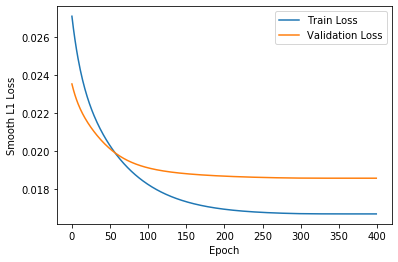

In [124]:
#show some results
plt.plot(history['train_epoch_loss'])
plt.plot(history['validate_epoch_loss'])
plt.legend(['Train Loss', 'Validation Loss'])
plt.xlabel('Epoch')
plt.ylabel('Smooth L1 Loss')
plt.show()

In [8]:
#evaluate performance on test set
#### Testing ####
state_dict = torch.load(os.path.join(model_save_path, 'Best_Brancher.pth'))
BRANCH_MODEL.load_state_dict(state_dict)
BRANCH_MODEL.eval()
ERROR, batch_n = 0,0
for i, (test_input, test_label) in enumerate(testLoader):
    batch_n += 1
    predicted_label = BRANCH_MODEL(test_input).view(1)
    test_error = score(predicted_label, test_label)
    ERROR += test_error
    
ERROR = ERROR / batch_n

print(f'Overall Error: {ERROR:.3f}')

Overall Error: 0.050


### 5. Branch Function Setup
<a id = 'function'></a>


In [19]:
def pair_to_length(pair, model_source = best_model_path):
    BL_Model = model()
    BL_Model.load_state_dict(torch.load(best_model_path))
    BL_Model.eval()
    converted_pair = barcode_det(pair[0], pair[1])[:,0:2].reshape(20,)
    pair_torch = torch.from_numpy(converted_pair).type(torch.FloatTensor)
    
    return BL_Model(pair_torch).item()

#test
parent = '1'*10
child = '1'*5 + '' + '1'*4
pair = [parent, child]
print(pair_to_length(pair))

0.2867802083492279


In [22]:
#test
parent = '1'*10
for i in range(10):
    for j in ['0','2']:
        child = '1'*(i) + j + '1'*(9 - i)
        pair = [parent, child]
        BL = pair_to_length(pair)
        print(f'Child: {child} | ', end = '')
        print(f'BL : {BL:.5f}\n')

Child: 0111111111 | BL : 0.29841

Child: 2111111111 | BL : 0.28130

Child: 1011111111 | BL : 0.19965

Child: 1211111111 | BL : 0.28782

Child: 1101111111 | BL : 0.19436

Child: 1121111111 | BL : 0.19341

Child: 1110111111 | BL : 0.21913

Child: 1112111111 | BL : 0.25191

Child: 1111011111 | BL : 0.20914

Child: 1111211111 | BL : 0.26638

Child: 1111101111 | BL : 0.32115

Child: 1111121111 | BL : 0.28678

Child: 1111110111 | BL : 0.23714

Child: 1111112111 | BL : 0.19966

Child: 1111111011 | BL : 0.24917

Child: 1111111211 | BL : 0.22848

Child: 1111111101 | BL : 0.26509

Child: 1111111121 | BL : 0.24193

Child: 1111111110 | BL : 0.16276

Child: 1111111112 | BL : 0.12832

